In [1]:
# !pip install seaborn

# Libraries Import

In [2]:
import os
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.preprocessing.image as image
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
# from keras.applications import VGG16
from keras.layers import Flatten, Dense
from keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from keras import backend as K
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

C:\Users\679644.ADIR\AppData\Roaming\Python\Python310\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\679644.ADIR\AppData\Roaming\Python\Python310\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, 

# Mounting a checkpoint due to high run time

In [3]:
checkpoint = ModelCheckpoint(filepath = "savedmodel/cnn-svm.hdfs", verbose = 1, save_best_only = True)

# Data Preprocessing

In [4]:
# Define the directories containing your image data
train_dir = 'D:/Emotion Recognition/train'
test_dir = 'D:/Emotion Recognition/test'
valid_dir = 'D:/Emotion Recognition/validation'

# Define the image size and batch size for the generators
img_size = (224, 224)
batch_size = 64

# Define the image data generators for the train, test, and validation data
train_datagen = ImageDataGenerator(
                rotation_range=20, # specifies the rotation to be 20%
                width_shift_range=0.1, # specifies the width shift of 10%
                height_shift_range=0.1, # specifies the height shift of 10%
                shear_range=0.20, # crops part of the image 
                zoom_range=0.20,  # zooms the image by 20%
                fill_mode='nearest', # fills using the nearest pixel 
                horizontal_flip=True, # Secifies the horizontal flip 
                rescale=1/255 # scales the image 
)

test_datagen = ImageDataGenerator(
                 rotation_range=20,# specifies the rotation to be 20%
                 width_shift_range=0.1, # specifies the width shift of 10%
                 height_shift_range=0.1,# specifies the height shift of 10%
                 shear_range=0.20, # crops part of the image 
                 zoom_range=0.20, # #zooms the image by 20%
                 fill_mode='nearest', # fills using the nearest pixel 
                 horizontal_flip=True, # Secifies the horizontal flip 
                 rescale=1/255 # scales the image 
)

valid_datagen = ImageDataGenerator(
                 rotation_range=20,# specifies the rotation to be 20%
                 width_shift_range=0.1, # specifies the width shift of 10%
                 height_shift_range=0.1,# specifies the height shift of 10%
                 shear_range=0.20, # crops part of the image 
                 zoom_range=0.20, # #zooms the image by 20%
                 fill_mode='nearest', # fills using the nearest pixel 
                 horizontal_flip=True, # Secifies the horizontal flip 
                 rescale=1/255 # scales the image 
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

valid_df = pd.DataFrame({'filename': os.listdir(valid_dir)})
valid_df['label'] = 'unknown'

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory=valid_dir,
    x_col='filename',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)

Found 32500 images belonging to 13 classes.
Found 9837 images belonging to 13 classes.
Found 131 validated image filenames belonging to 1 classes.


# The Hyrid model

## CNN Layer

In [6]:
# Train and get the features from the CNN model
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, padding="same", kernel_size=3, activation='relu', input_shape=[224, 224, 1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, padding="same", kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Conv2D(filters=128, padding='same', kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, padding='same', kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=13, activation='softmax')
])

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# cnn_history = cnn.fit(train_generator, validation_data=valid_generator, epochs=10)

## Feature extraction

In [7]:
# from tensorflow.keras.callbacks import ProgbarLogger

# progress_bar = ProgbarLogger()
cnn_history = cnn.fit(train_generator, validation_data=valid_generator, epochs=10, callbacks = [checkpoint]) #, callbacks=[progress_bar])


# Extract features from the CNN
feature_extractor = tf.keras.models.Model(inputs=cnn.inputs, outputs=cnn.layers[-2].output)

# Function to extract features from the dataset
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 256))
    labels = np.zeros(shape=(sample_count,))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = feature_extractor.predict(inputs_batch)
        batch_size = inputs_batch.shape[0]
        features[i : i + batch_size] = features_batch
        labels[i : i + batch_size] = np.argmax(labels_batch, axis=1)
        i += batch_size
        if i >= sample_count:
            break
    return features, labels

Epoch 1/10
508/508 [==============================] - ETA: 0s - loss: 3.5568 - accuracy: 0.0757
Epoch 1: val_loss improved from inf to 95.90359, saving model to savedmodel\cnn-svm.hdfs


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


508/508 [==============================] - 208s 392ms/step - loss: 3.5568 - accuracy: 0.0757 - val_loss: 95.9036 - val_accuracy: 0.2824
Epoch 2/10
508/508 [==============================] - ETA: 0s - loss: 2.5654 - accuracy: 0.0760
Epoch 2: val_loss improved from 95.90359 to 33.34449, saving model to savedmodel\cnn-svm.hdfs


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


508/508 [==============================] - 65s 128ms/step - loss: 2.5654 - accuracy: 0.0760 - val_loss: 33.3445 - val_accuracy: 1.0000
Epoch 3/10
508/508 [==============================] - ETA: 0s - loss: 2.5651 - accuracy: 0.0724
Epoch 3: val_loss improved from 33.34449 to 33.34446, saving model to savedmodel\cnn-svm.hdfs


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


508/508 [==============================] - 65s 127ms/step - loss: 2.5651 - accuracy: 0.0724 - val_loss: 33.3445 - val_accuracy: 0.0000e+00
Epoch 4/10
508/508 [==============================] - ETA: 0s - loss: 2.5652 - accuracy: 0.0740
Epoch 4: val_loss did not improve from 33.34446
508/508 [==============================] - 62s 121ms/step - loss: 2.5652 - accuracy: 0.0740 - val_loss: 33.3445 - val_accuracy: 0.0000e+00
Epoch 5/10
508/508 [==============================] - ETA: 0s - loss: 2.5751 - accuracy: 0.0725
Epoch 5: val_loss did not improve from 33.34446
508/508 [==============================] - 62s 123ms/step - loss: 2.5751 - accuracy: 0.0725 - val_loss: 33.3447 - val_accuracy: 1.0000
Epoch 6/10
508/508 [==============================] - ETA: 0s - loss: 2.5652 - accuracy: 0.0757
Epoch 6: val_loss did not improve from 33.34446
508/508 [==============================] - 64s 126ms/step - loss: 2.5652 - accuracy: 0.0757 - val_loss: 33.3445 - val_accuracy: 0.0000e+00
Epoch 7/10
508/5

INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


508/508 [==============================] - 174s 342ms/step - loss: 2.5651 - accuracy: 0.0744 - val_loss: 33.3445 - val_accuracy: 0.0000e+00


## SVM Layer

In [8]:
# Extract features from the training, testing, and validation sets
train_samples = train_generator.n
valid_samples = valid_generator.n
test_samples = test_generator.n

train_features, train_labels = extract_features(train_generator, train_samples)
test_features, test_labels = extract_features(test_generator, test_samples)
valid_features, valid_labels = extract_features(valid_generator, valid_samples)

# Train an SVM classifier
svm = SVC(kernel='linear', C=1, probability=True)
svm.fit(train_features, train_labels)

# Evaluate the SVM classifier
train_preds = svm.predict(train_features)
test_preds = svm.predict(test_features)

train_accuracy = accuracy_score(train_labels, train_preds)
test_accuracy = accuracy_score(test_labels, test_preds)
print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

2/2 [==============================] - 0s 34ms/step


2/2 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 9ms/step
Train accuracy: 0.07692307692307693
Test accuracy: 0.050930161634644706


## Plots for the CNN and SVM Accuracies

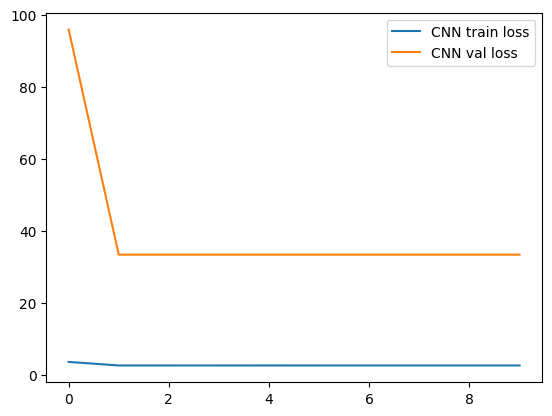

<Figure size 640x480 with 0 Axes>

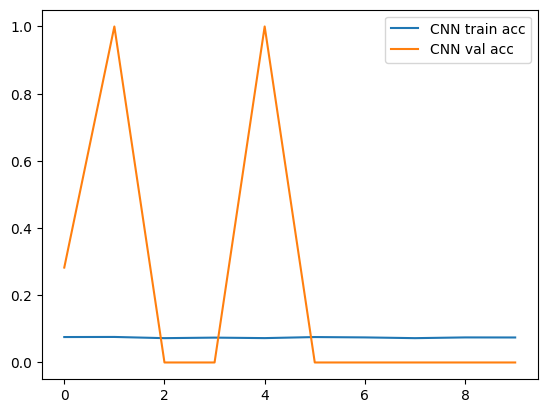

<Figure size 640x480 with 0 Axes>

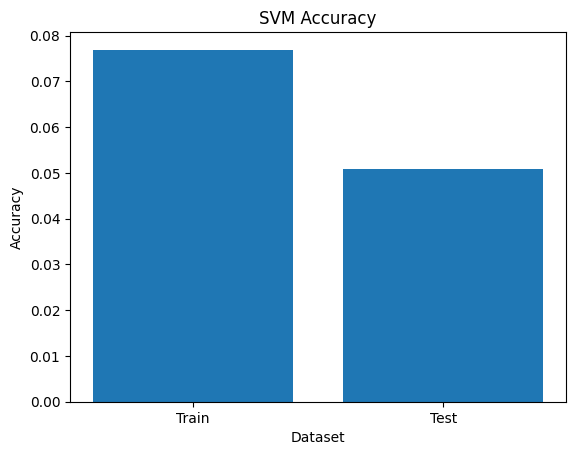

<Figure size 640x480 with 0 Axes>

In [9]:
# Plot the loss and accuracy for the CNN model
plt.figure()
plt.plot(cnn_history.history['loss'], label='CNN train loss')
plt.plot(cnn_history.history['val_loss'], label='CNN val loss')
plt.legend()
plt.show()
plt.savefig('CNN_LossVal_loss')

plt.figure()
plt.plot(cnn_history.history['accuracy'], label='CNN train acc')
plt.plot(cnn_history.history['val_accuracy'], label='CNN val acc')
plt.legend()
plt.show()
plt.savefig('CNN_AccVal_acc')

# Plot the accuracy for the SVM model
plt.figure()
plt.bar(['Train', 'Test'], [train_accuracy, test_accuracy])
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy')
plt.show()
plt.savefig('SVM_Accuracy')

# Preprocessing Streamlined Dataset

In [10]:
# Define the directories containing your image data
train_dir = 'D:\\Emotion Recognition\\dataset\\train'
img_size = (224, 224)
batch_size = 64

# Create a dataframe with filenames and their corresponding labels
filepaths = []
labels = []

for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith('.jpg'):
            filepaths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

# Create a DataFrame
data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Shuffle the DataFrame
data_df = data_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate the validation split size
valid_split_size = int(len(data_df) * 0.2)

# Split the DataFrame into train and validation DataFrames
valid_df = data_df.iloc[:valid_split_size]
train_df = data_df.iloc[valid_split_size:]

# Define the image data generators for the train and validation data
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.20,
    zoom_range=0.20,
    fill_mode='nearest',
    horizontal_flip=True,
    rescale=1/255
)

valid_datagen = ImageDataGenerator(rescale=1/255)

In [11]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale'
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory=train_dir,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)

Found 30180 validated image filenames belonging to 2 classes.
Found 7544 validated image filenames belonging to 2 classes.


## Visualization

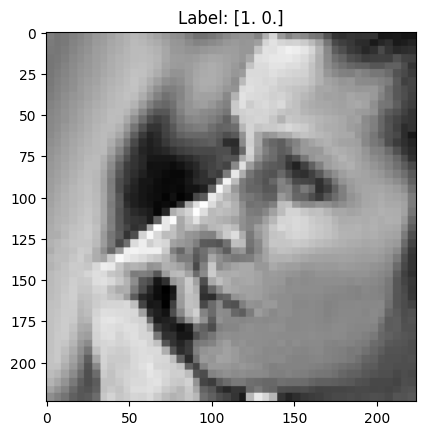

In [12]:
# Get the next batch of images and labels from the train generator
x_batch, y_batch = next(valid_generator)

# Display the first image in the batch
plt.imshow(x_batch[18].squeeze(), cmap='gray')
plt.title(f"Label: {y_batch[18]}")
plt.show()


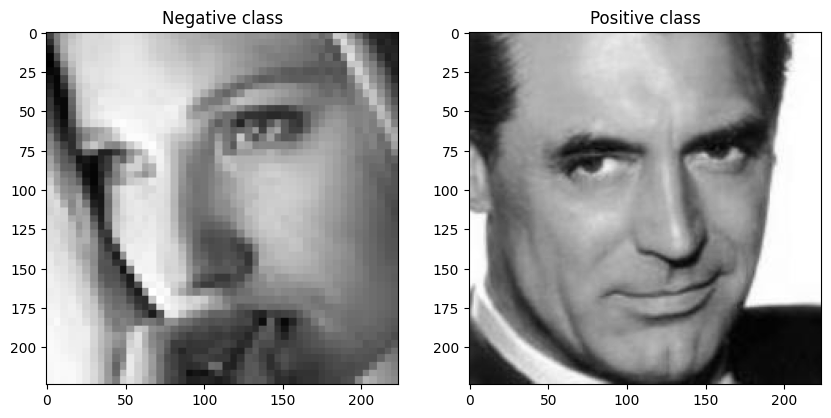

In [13]:
# Get the next batch of images and labels from the valid generator
x_batch, y_batch = next(valid_generator)

# Initialize variables to store an example image from each class
example_positive = None
example_negative = None

# Iterate through images and labels in the batch
for img, label in zip(x_batch, y_batch):
    if example_negative is None and label[0] == 1:
        example_negative = img
    elif example_positive is None and label[1] == 1:
        example_positive = img

    # Break the loop if an example image for each class has been found
    if example_negative is not None and example_positive is not None:
        break

# Display the example images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(example_negative.squeeze(), cmap='gray')
axes[0].set_title('Negative class')
axes[1].imshow(example_positive.squeeze(), cmap='gray')
axes[1].set_title('Positive class')

plt.show()


# Hyrid CNN+SVM Model

## CNN Layer

In [14]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=64,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[224, 224, 1]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=64,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))

# # Adding a SVM layer
# cnn.add(tfa.layers.SoftmaxCategoricalSVM(num_classes=13, kernel_size=3, kernel_regularizer=tf.keras.regularizers.l2(0.01)))

# Step 5 - Output Layer
#cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
## For Binary Classification
# cnn.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
#              ='linear'))

## for multiclassification
cnn.add(Dense(2, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='softmax'))

In [15]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [16]:
print(f"Train generator image shape: {train_generator.image_shape}")
print(f"Validation generator image shape: {valid_generator.image_shape}")


Train generator image shape: (224, 224, 1)
Validation generator image shape: (224, 224, 1)


In [17]:
x_batch, y_batch = next(train_generator)
print("Sample batch shape:", x_batch.shape)
print("Sample labels shape:", y_batch.shape)


Sample batch shape: (64, 224, 224, 1)
Sample labels shape: (64, 2)


In [18]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn.fit(train_generator, validation_data=valid_generator, epochs=10, callbacks = [checkpoint])


Epoch 1/10
472/472 [==============================] - ETA: 0s - loss: 0.6512 - accuracy: 0.6593
Epoch 1: val_loss improved from 33.34445 to 0.62053, saving model to savedmodel\cnn-svm.hdfs


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


472/472 [==============================] - 215s 454ms/step - loss: 0.6512 - accuracy: 0.6593 - val_loss: 0.6205 - val_accuracy: 0.6584
Epoch 2/10
472/472 [==============================] - ETA: 0s - loss: 0.6258 - accuracy: 0.6629
Epoch 2: val_loss improved from 0.62053 to 0.60726, saving model to savedmodel\cnn-svm.hdfs


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


472/472 [==============================] - 61s 128ms/step - loss: 0.6258 - accuracy: 0.6629 - val_loss: 0.6073 - val_accuracy: 0.6584
Epoch 3/10
472/472 [==============================] - ETA: 0s - loss: 0.6184 - accuracy: 0.6629
Epoch 3: val_loss improved from 0.60726 to 0.59830, saving model to savedmodel\cnn-svm.hdfs


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


472/472 [==============================] - 61s 128ms/step - loss: 0.6184 - accuracy: 0.6629 - val_loss: 0.5983 - val_accuracy: 0.6584
Epoch 4/10
472/472 [==============================] - ETA: 0s - loss: 0.6142 - accuracy: 0.6629
Epoch 4: val_loss did not improve from 0.59830
472/472 [==============================] - 59s 125ms/step - loss: 0.6142 - accuracy: 0.6629 - val_loss: 0.6049 - val_accuracy: 0.6584
Epoch 5/10
472/472 [==============================] - ETA: 0s - loss: 0.6125 - accuracy: 0.6682
Epoch 5: val_loss improved from 0.59830 to 0.59175, saving model to savedmodel\cnn-svm.hdfs


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


472/472 [==============================] - 61s 128ms/step - loss: 0.6125 - accuracy: 0.6682 - val_loss: 0.5918 - val_accuracy: 0.6776
Epoch 6/10
472/472 [==============================] - ETA: 0s - loss: 0.6074 - accuracy: 0.6773
Epoch 6: val_loss did not improve from 0.59175
472/472 [==============================] - 59s 125ms/step - loss: 0.6074 - accuracy: 0.6773 - val_loss: 0.6107 - val_accuracy: 0.6633
Epoch 7/10
472/472 [==============================] - ETA: 0s - loss: 0.5998 - accuracy: 0.6890
Epoch 7: val_loss did not improve from 0.59175
472/472 [==============================] - 59s 125ms/step - loss: 0.5998 - accuracy: 0.6890 - val_loss: 0.6159 - val_accuracy: 0.6799
Epoch 8/10
472/472 [==============================] - ETA: 0s - loss: 0.5951 - accuracy: 0.6923
Epoch 8: val_loss improved from 0.59175 to 0.56983, saving model to savedmodel\cnn-svm.hdfs


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


472/472 [==============================] - 61s 129ms/step - loss: 0.5951 - accuracy: 0.6923 - val_loss: 0.5698 - val_accuracy: 0.7238
Epoch 9/10
472/472 [==============================] - ETA: 0s - loss: 0.5899 - accuracy: 0.6981
Epoch 9: val_loss improved from 0.56983 to 0.55699, saving model to savedmodel\cnn-svm.hdfs


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


472/472 [==============================] - 61s 129ms/step - loss: 0.5899 - accuracy: 0.6981 - val_loss: 0.5570 - val_accuracy: 0.7328
Epoch 10/10
472/472 [==============================] - ETA: 0s - loss: 0.5858 - accuracy: 0.7014
Epoch 10: val_loss improved from 0.55699 to 0.54737, saving model to savedmodel\cnn-svm.hdfs


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


INFO:tensorflow:Assets written to: savedmodel\cnn-svm.hdfs\assets


472/472 [==============================] - 61s 128ms/step - loss: 0.5858 - accuracy: 0.7014 - val_loss: 0.5474 - val_accuracy: 0.7439


In [19]:
train_samples = train_generator.n
valid_samples = valid_generator.n
# test_samples = test_generator.n

print(f"Number of train samples: {train_samples}")
print(f"Number of validation samples: {valid_samples}")
# print(f"Number of test samples: {test_samples}")


Number of train samples: 30180
Number of validation samples: 7544


## Feature Extraction

In [20]:
# Extract features from the CNN
feature_extractor = tf.keras.models.Model(inputs=cnn.inputs, outputs=cnn.layers[-2].output)

# Function to extract features from the dataset
def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 256))
    labels = np.zeros(shape=(sample_count,))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = feature_extractor.predict(inputs_batch)
        batch_size = inputs_batch.shape[0]
        features[i : i + batch_size] = features_batch
        labels[i : i + batch_size] = np.argmax(labels_batch, axis=1)
        i += batch_size
        if i >= sample_count:
            break
    return features, labels



# Extract features from the training, testing, and validation sets
train_samples = train_generator.n
valid_samples = valid_generator.n
# test_samples = test_generator.n

train_features, train_labels = extract_features(train_generator, train_samples)
# test_features, test_labels = extract_features(test_generator, test_samples)
valid_features, valid_labels = extract_features(valid_generator, valid_samples)

# Train an SVM classifier
svm = SVC(kernel='linear', C=1, probability=True)
svm.fit(train_features, train_labels)

# Evaluate the SVM classifier
train_preds = svm.predict(train_features)
# test_preds = svm.predict(test_features)
valid_preds = svm.predict(valid_features)


train_accuracy = accuracy_score(train_labels, train_preds)
# test_accuracy = accuracy_score(test_labels, test_preds)
valid_accuracy = accuracy_score(valid_labels, valid_preds)

print("Train accuracy:", train_accuracy)
# print("Test accuracy:", test_accuracy)
print("Validation accuracy:", valid_accuracy)


2/2 [==============================] - 0s 54ms/step


2/2 [==============================] - 0s 2ms/step
Train accuracy: 0.7072233267064281
Validation accuracy: 0.7387327677624602


## Plots for the CNN and SVM Accuracies

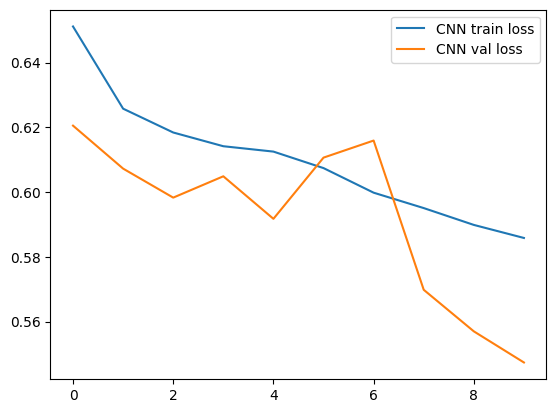

<Figure size 640x480 with 0 Axes>

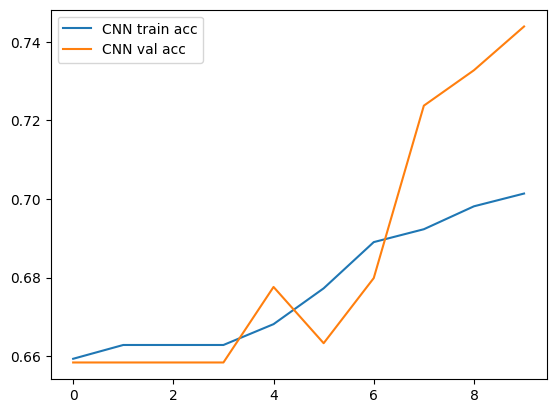

<Figure size 640x480 with 0 Axes>

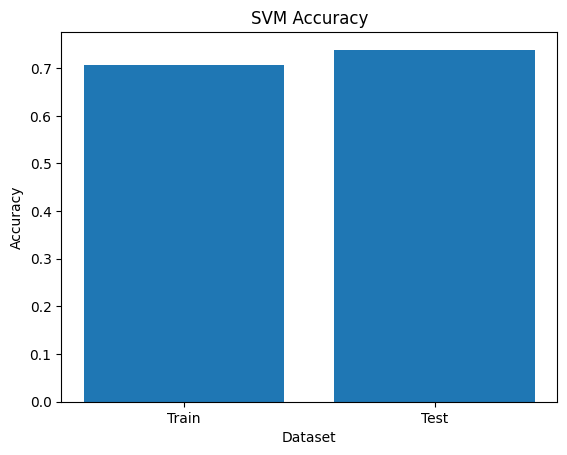

<Figure size 640x480 with 0 Axes>

In [21]:
# Plot the loss and accuracy for the CNN model
plt.figure()
plt.plot(cnn_history.history['loss'], label='CNN train loss')
plt.plot(cnn_history.history['val_loss'], label='CNN val loss')
plt.legend()
plt.show()
plt.savefig('CNN_LossVal_loss')

plt.figure()
plt.plot(cnn_history.history['accuracy'], label='CNN train acc')
plt.plot(cnn_history.history['val_accuracy'], label='CNN val acc')
plt.legend()
plt.show()
plt.savefig('CNN_AccVal_acc')

# Plot the accuracy for the SVM model
plt.figure()
plt.bar(['Train', 'Test'], [train_accuracy, valid_accuracy])
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy')
plt.show()
plt.savefig('SVM_Accuracy')

# Hyperparameter Tuning

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score


In [23]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],  # only applicable for 'poly' kernel
    'gamma': ['scale', 'auto'],  # only applicable for 'rbf' and 'poly' kernel
}


In [26]:
from sklearn.model_selection import RandomizedSearchCV

svm = SVC(probability=True)

random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_grid,
    n_iter=10,  # number of random combinations to try
    scoring=make_scorer(accuracy_score),
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
random_search.fit(train_features, train_labels)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'degree': [2, 3, 4],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'rbf', 'poly']},
                   random_state=42, scoring=make_scorer(accuracy_score),
                   verbose=2)

In [27]:
# Get the best parameters
best_params = random_search.best_params_
print("Best parameters:", best_params)


Best parameters: {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'C': 1}


In [28]:
# Evaluate the model

best_svm = SVC(**best_params, probability=True)
best_svm.fit(train_features, train_labels)

train_preds = best_svm.predict(train_features)
valid_preds = best_svm.predict(valid_features)

train_accuracy = accuracy_score(train_labels, train_preds)
valid_accuracy = accuracy_score(valid_labels, valid_preds)

print("Train accuracy (best SVM):", train_accuracy)
print("Validation accuracy (best SVM):", valid_accuracy)


Train accuracy (best SVM): 0.7132538104705103
Validation accuracy (best SVM): 0.7493372216330859


## Classification report and confusion matrix

Train classification report dataframe:


,precision,recall,f1-score,support
0.0,0.720680,0.926465,0.810717,20004.000000
1.0,0.670475,0.294123,0.408880,10176.000000
accuracy,0.713254,0.713254,0.713254,0.713254
macro avg,0.695577,0.610294,0.609799,30180.000000
weighted avg,0.703752,0.713254,0.675227,30180.000000






Validation classification report dataframe:


,precision,recall,f1-score,support
0.0,0.750570,0.927522,0.829716,4967.000000
1.0,0.743954,0.405898,0.525232,2577.000000
accuracy,0.749337,0.749337,0.749337,0.749337
macro avg,0.747262,0.666710,0.677474,7544.000000
weighted avg,0.748310,0.749337,0.725706,7544.000000


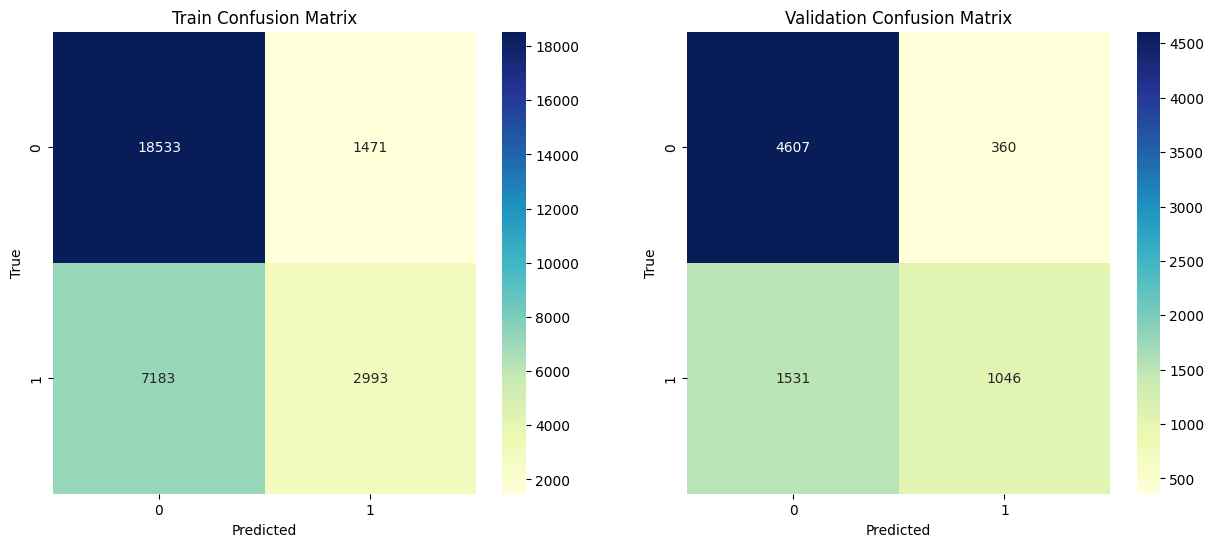

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

# Compute classification reports as dictionaries
train_report_dict = classification_report(train_labels, train_preds, output_dict=True)
valid_report_dict = classification_report(valid_labels, valid_preds, output_dict=True)

# Convert dictionaries to dataframes
train_report_df = pd.DataFrame(train_report_dict).transpose()
valid_report_df = pd.DataFrame(valid_report_dict).transpose()

# Display dataframes
print("Train classification report dataframe:")
display(train_report_df)

print()
print()
print()

print("\nValidation classification report dataframe:")
display(valid_report_df)

print()
print()
print()

# Compute confusion matrices
train_cm = confusion_matrix(train_labels, train_preds)
valid_cm = confusion_matrix(valid_labels, valid_preds)

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(train_cm, annot=True, fmt="d", cmap="YlGnBu", ax=ax1)
ax1.set_title("Train Confusion Matrix")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")

sns.heatmap(valid_cm, annot=True, fmt="d", cmap="YlGnBu", ax=ax2)
ax2.set_title("Validation Confusion Matrix")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("True")

plt.show()


## ROC Curve

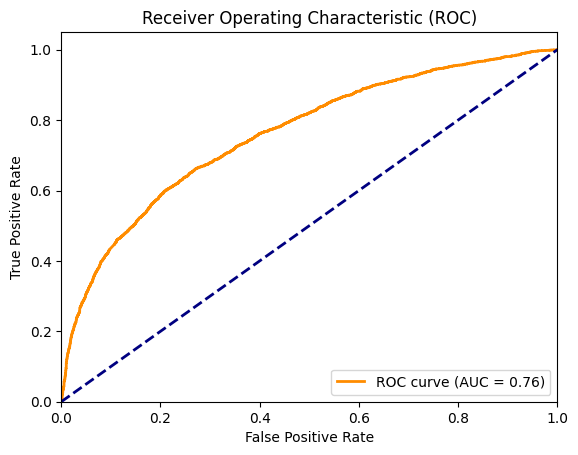

In [43]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Train an SVM classifier
svm = SVC(kernel='linear', C=1, probability=True)
svm.fit(train_features, train_labels)

# Get the predicted probabilities for the positive class
valid_probs = svm.predict_proba(valid_features)[:, 1]

# Calculate the FPR and TPR for various thresholds
fpr, tpr, thresholds = roc_curve(valid_labels, valid_probs)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
